# County-level earthquake risk maps

Several of our natural disasters are reported at the county level, so we'd like earthquake data to be available at the county level also.  What we have is a USA-wide map with contours of earthquake risk, from [this source](https://geo.nyu.edu/catalog/stanford-rm034qp5477), and a map of all the counties in the USA, from [this source](https://community.esri.com/thread/24614).

In a previous notebook (DMA1) I processed the contour map. In this notebook I calculate the average values of earthquake risk per county, and export the resulting map for future processing.

## Units and code names

I talk about earthquake risk throughout this notebook, though technically what we have is the maximum acceleration that has a 10% probability of being caused by earthquakes during the next 50 years. Since this is acceleration at ground level, and expressed as a percent of standard gravity, some sources call it percent ground acceleration (`pga`) or `percent_g`.

From the source:
```
The data represent a model showing the probability that ground motion will reach a certain level. This map layer shows peak horizontal ground acceleration (the fastest measured change in speed, for a particle at ground level that is moving horizontally due to an earthquake) with a 10% probability of exceedance in 50 years. Values are given in %g, where g is acceleration due to gravity, or 9.8 meters/second^2.
```

[FIPS codes](https://en.wikipedia.org/wiki/FIPS_county_code) are unique identifiers for used by the US government for identifying states and counties (or county-equivalent areas). Each county has a full FIPS code that contains two digits for the state and three for the county within that state.

In [1]:
import numpy as np
import geopandas
import pandas as pd

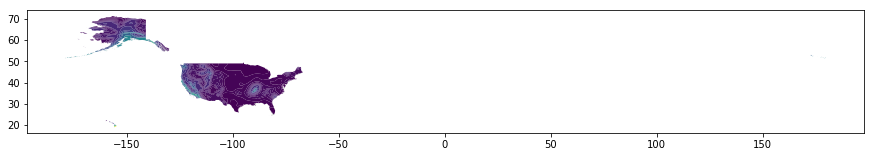

In [10]:
# Import previously-created map of earthquake risk contour lines.
quakes = geopandas.read_file('../data_output/1__quake_contour/')

# Plot full map including all territories
quakes.plot(column='pga', figsize=(15,15));

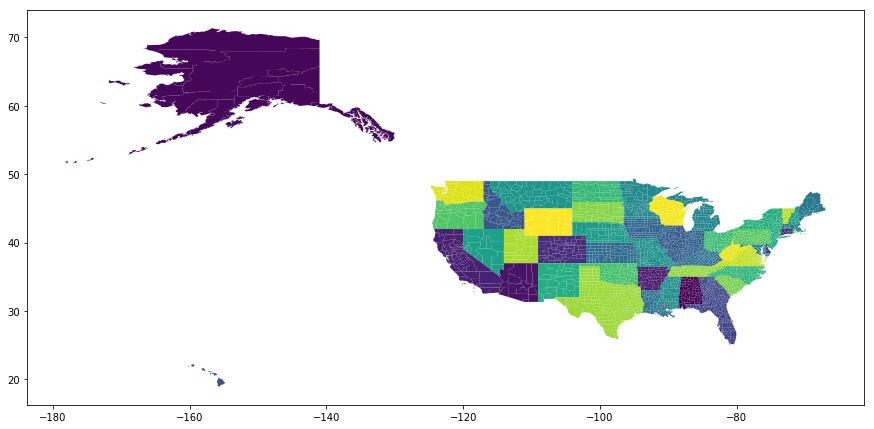

In [11]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)
    
# County shapes, with brighter colors tied to higher state codes
counties.plot(column='STATE_FIPS', figsize=(15,15));

In [12]:
print(counties.shape)
counties.head(5)

(3141, 6)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,..."
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,..."
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...


In [13]:
"""
Contour lines are wide apart in the middle of the country and close
together in geologically active areas.  In order to 
produce a single value for each county, I will note which contour
regions intersect each county and average up their PGA values.  This
ignores the relative area of all the intersections, which is a decent
approximation for most of the country other than Alaska and
California (which both have large counties and steep gradients of 
earthquake risk).  
"""

# Create a dataframe of intersections; one row gets generated
# for each risk contour that intersects the county.
intersections = geopandas.sjoin(counties, quakes, how="inner", 
                                op='intersects')

# The Geopandas dissolve function aggregates rows with the same value in a 
# given column, in this case the unique county code.
counties_avg_quake = intersections.dissolve(by='FIPS', aggfunc='mean')

# Once I have aggregate numbers for each county, I put them into a dictionary
avg_quake_dict = counties_avg_quake['pga'].to_dict()

# Apply the dictionary to each county in the original dataset.
counties['pga'] = counties['FIPS'].map(avg_quake_dict)

In [14]:
print(counties.shape)
counties.head()

(3141, 7)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,pga
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",0.500000
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...,6.000000
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,...",5.500000
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",8.333333
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...,5.500000


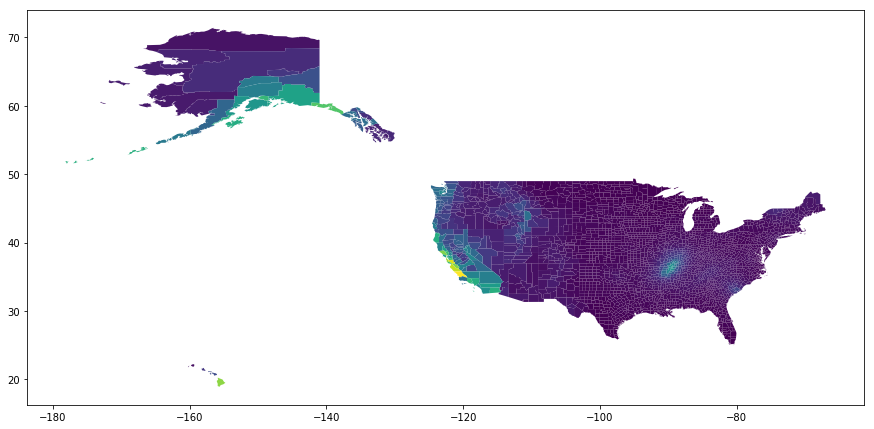

In [15]:
# This is what the county-averaged risk looks for the whole country.
# Note that the territories not included in our county map have been dropped.
counties.plot(column='pga', figsize=(15,15));

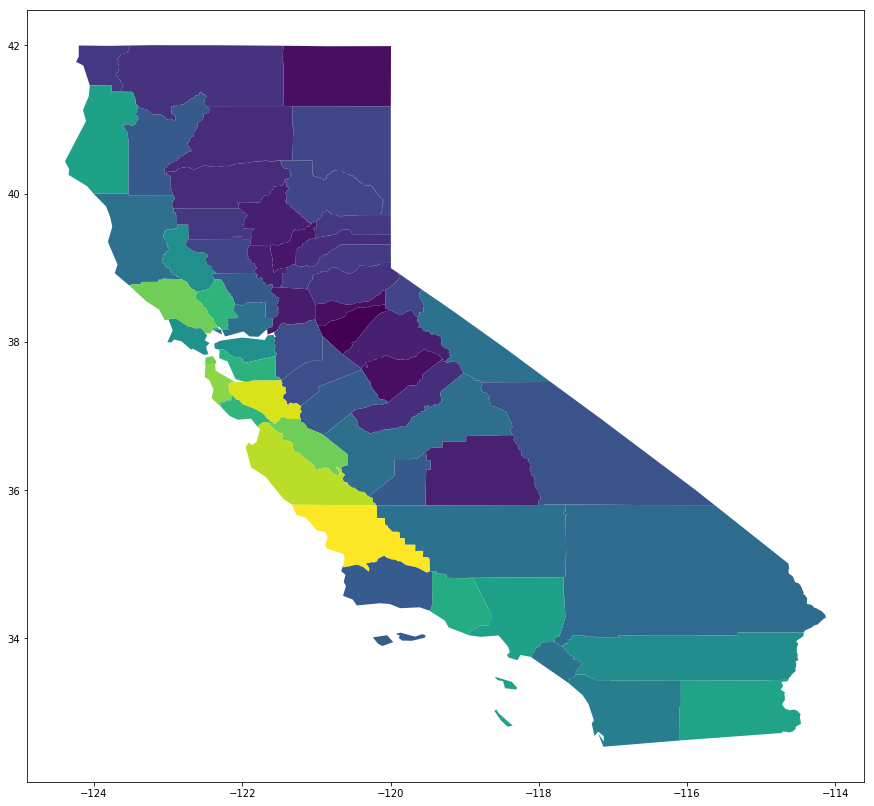

In [16]:
# And here's what it rooks like for California
counties[counties.STATE_NAME=='California'].plot(column='pga', figsize=(15,15));

In [ ]:
# Export as a SHP file.
counties.to_file('../data_output/2__quake_cunt')